In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import awkward as ak
import dask
from hist.dask import Hist
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema, BaseSchema
from coffea.analysis_tools import PackedSelection
import mplhep
import uproot
import coffea.nanoevents

PHYSLITESchema.warn_missing_crossrefs = False

In [2]:
from importlib.metadata import version

for package in ["numpy", "awkward", "uproot", "coffea", "dask"]:
    print(f"# {package}: v{version(package)}")

# numpy: v1.24.3
# awkward: v2.6.7
# uproot: v5.3.10
# coffea: v2024.8.0
# dask: v2023.5.0


In [3]:
# s3df file path
#file_path = "/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
# uchicago file path
file_path = "/data/dliu64/Higgs_analysis/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
file_path=f"{file_path}{':evttree'}"

In [4]:
def filter_name(name):
    return name in [
        'fatJetGN2XHbb', 'fatJetGN2XHcc', 
        'fatJetGN2XQCD', 'fatJetPt',
        'fatJetPx', 'fatJetPy',
        'fatJetPz', 'fatJetE',
        'fatJetM', 'fatJetNCHadrons', 
        'fatJetNBHadrons', 'vrJetIdFatJet', 
        'vrJetHadronGhostTruthLabelID', 'vrJetPt', 
        'vrJetM', 'eventMCWeight'
    ]

In [5]:
events = NanoEventsFactory.from_root(
    file_path,
    schemaclass=BaseSchema,
    uproot_options=dict(filter_name=filter_name),
    delayed=True,
).events()

In [65]:
fatjetpt = events.fatJetPt.compute()
N_tot = len(events.compute())
N_max_fatjet = ak.max(ak.num(fatjetpt))
print('The maximum number of fatjets is %i'%N_max_fatjet)
for i in range(N_max_fatjet):
    print('The number of events with %i fatjet(s) is %i, fraction is %.1f%%'%(i+1, len(fatjetpt[ak.num(fatjetpt)==i+1]), len(fatjetpt[ak.num(fatjetpt)==i+1])/N_tot*100))

The maximum number of fatjets is 7
The number of events with 1 fatjet(s) is 473620, fraction is 11.6%
The number of events with 2 fatjet(s) is 3190476, fraction is 78.2%
The number of events with 3 fatjet(s) is 376796, fraction is 9.2%
The number of events with 4 fatjet(s) is 24284, fraction is 0.6%
The number of events with 5 fatjet(s) is 1180, fraction is 0.0%
The number of events with 6 fatjet(s) is 43, fraction is 0.0%
The number of events with 7 fatjet(s) is 2, fraction is 0.0%


In [58]:
vrjet = events.vrJetIdFatJet.compute()
vrjet[ak.num(vrjet[vrjet==6])>0]

<Array [[0, 0, 0, 0, 0, ..., 4, 5, 5, 6], ...] type='2 * [var * int32[param...'>

In [6]:
vrjetpt = events.vrJetPt.compute()
vrjetpt

<Array [[6.65, 375, 12.1, 314], ..., [...]] type='4078050 * [var * float32[...'>

In [41]:
selection_2fatjet = ak.num(fatjetpt, axis=-1) == 2
selection_1fatjet = ak.num(fatjetpt, axis=-1) == 1
selection_multi_fatjet = ak.num(fatjetpt, axis=-1) > 2
event_1fatjet = events[selection_1fatjet].compute()
event_2fatjet = events[selection_2fatjet].compute()
event_multi_fatjet = events[selection_multi_fatjet].compute()
tot_N = len(events.compute())
single_N = len(event_1fatjet)
double_N = len(event_2fatjet)
multi_N = len(event_multi_fatjet)
print('total event number is %i,\nsingle fatjet events are %i, %.3f%%,\ndouble fatjets events are %i, %.3f%%,\nmulti fatjets events are %i, %.3f%%'\
      %(tot_N, single_N, single_N/tot_N*100, double_N, double_N/tot_N*100, multi_N, multi_N/tot_N*100))

total event number is 4078050,
single fatjet events are 473620, 11.614%,
double fatjets events are 3190476, 78.235%,
multi fatjets events are 402305, 9.865%


The range of leading fatjet pT is from 200.7 to 1520.8 GeV
The range of subleading fatjet pT is from 200.0 to 1406.8 GeV


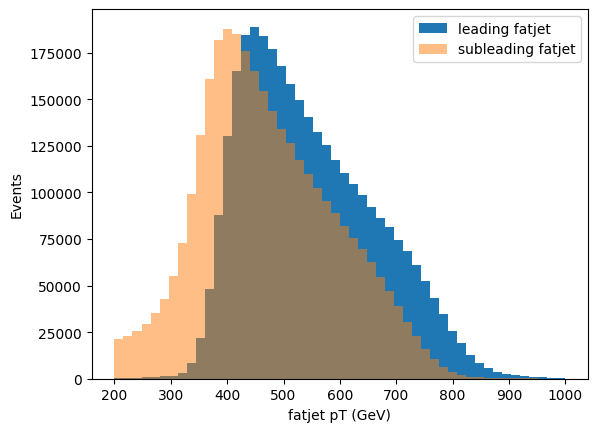

In [38]:
pT_leading_fatjet = events.fatJetPt[selection_2fatjet][:,0].compute()
pT_subleading_fatjet = events.fatJetPt[selection_2fatjet][:,1].compute()
print('The range of leading fatjet pT is from %.1f to %.1f GeV'%(ak.min(pT_leading_fatjet),ak.max(pT_leading_fatjet)))
print('The range of subleading fatjet pT is from %.1f to %.1f GeV'%(ak.min(pT_subleading_fatjet),ak.max(pT_subleading_fatjet)))

plt.hist(pT_leading_fatjet, bins=50, range=(200, 1000), label='leading fatjet')
plt.hist(pT_subleading_fatjet, bins=50, range=(200, 1000), alpha=.5, label='subleading fatjet')
plt.xlabel(r"fatjet pT (GeV)")
plt.ylabel("Events")
plt.legend()

The range of leading fatjet mass is from -0.0 to 866.3 GeV
The range of subleading fatjet mass is from -0.0 to 683.3 GeV


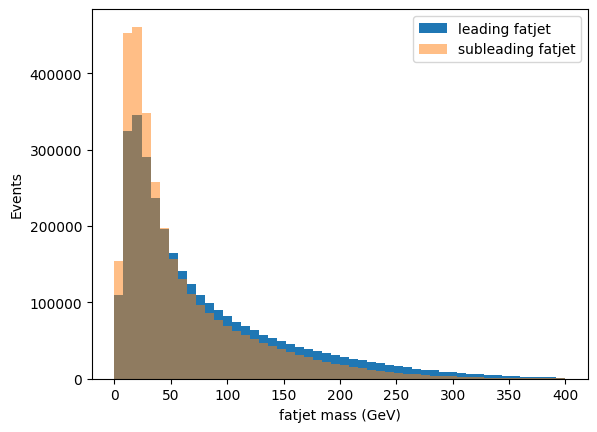

In [35]:
mass_leading_fatjet = events.fatJetM[selection_2fatjet][:,0].compute()
mass_subleading_fatjet = events.fatJetM[selection_2fatjet][:,1].compute()
print('The range of leading fatjet mass is from %.1f to %.1f GeV'%(ak.min(mass_leading_fatjet),ak.max(mass_leading_fatjet)))
print('The range of subleading fatjet mass is from %.1f to %.1f GeV'%(ak.min(mass_subleading_fatjet),ak.max(mass_subleading_fatjet)))

plt.hist(mass_leading_fatjet, bins=50, range=(0, 400), label='leading fatjet')
plt.hist(mass_subleading_fatjet, bins=50, range=(0, 400), alpha=.5, label='subleading fatjet')
plt.xlabel(r"fatjet mass (GeV)")
plt.ylabel("Events")
plt.legend()

# Questions
1. How to calculate fatjet pT? Is there any relationship between vrjets pT and fatjet pT?
2. Where to get the 4 momentum info? How do convert from (px, py, pz, E) to (phi, eta, pT, m)? Where do those fat jets come from (trigger system?) what's the delta R distribution?
3. How to sort awkward array in a more efficient way? vrjetpT are not sorted. How to build a sorted array?
4. How to use dash to accelerate coffea? Should I use dash at all if I can apply enough CPU for jupyter notebook?
5. How to make sure that leading fatjet do come from Higgs? Why do we only care about leading fatjet?

In [ ]:
dr = events[selection_2fatjet][:, 0].delta_r(events[selection_2fatjet][:, 1])

In [20]:
vrjet_id_0 = vrjet==0
vrjet_id_1 = vrjet==1
# pick vrjet whose id is 0
vrjetpt_id_0 = vrjetpt[vrjet_id_0]
vrjetpt_id_0= vrjetpt_id_0[ak.num(vrjetpt_id_0)>1]
print(len(vrjetpt_id_0))
# check whether it has been sorted or not
vrjetpt_id_0[(vrjetpt_id_0[:,-1] - vrjetpt_id_0[:,-2])>0]
#print(len(vrjetpt_id_0[(vrjetpt_id_0[:,-1] - vrjetpt_id_0[:,-2])>0]))
#vrjetpt_id_1 = vrjetpt[vrjet_id_1]

3650515


<Array [[9.52, 322, 90.3], ..., [7.56, ...]] type='221657 * var * float32[p...'>

In [51]:
events.vrJetHadronGhostTruthLabelID.compute()

<Array [[0, 0, 0, 0], ..., [0, 0, ..., 0, 0]] type='4078050 * [var * int32[...'>